In [2]:
# IGNORE THIS LINE WHICH MODIFIES LAYOUT AND STYLING OF THE NOTEBOOK !
from IPython.core.display import HTML; HTML(open("custom.html", "r").read())

# Chapter 7: Regression

Regression belongs like classification to the field of supervised learning. The main difference is that regression tries to predict numerical values in contrast to classification where we predict categories.

Other differences are:

* Accuracy is measured differently

* Other algorithms

## Example: Salmon weight

The dataset `salmon.csv` holds measurements of `circumference`, `length` and `weight` for  `atlantic` and `sockeye` salmons.

Our goal is to predict `weight` based on the other three features.

In [206]:
import pandas as pd

df = pd.read_csv("salmon.csv")
df.head()

circumference  length      kind  weight
0           25.5    85.5  atlantic    31.2
1           22.5    62.5  atlantic    12.4
2           29.0    88.0  atlantic    34.8
3           32.5    85.5  atlantic    62.7
4           24.5    74.5  atlantic    24.2

In [207]:
df.tail()

circumference  length     kind  weight
95           19.0    69.5  sockeye    18.8
96           18.5    67.0  sockeye    18.9
97           24.5    67.5  sockeye    24.7
98           21.0    66.5  sockeye    26.0
99           27.5    86.5  sockeye    43.4

In [208]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Let us inspect the features and their distributions:

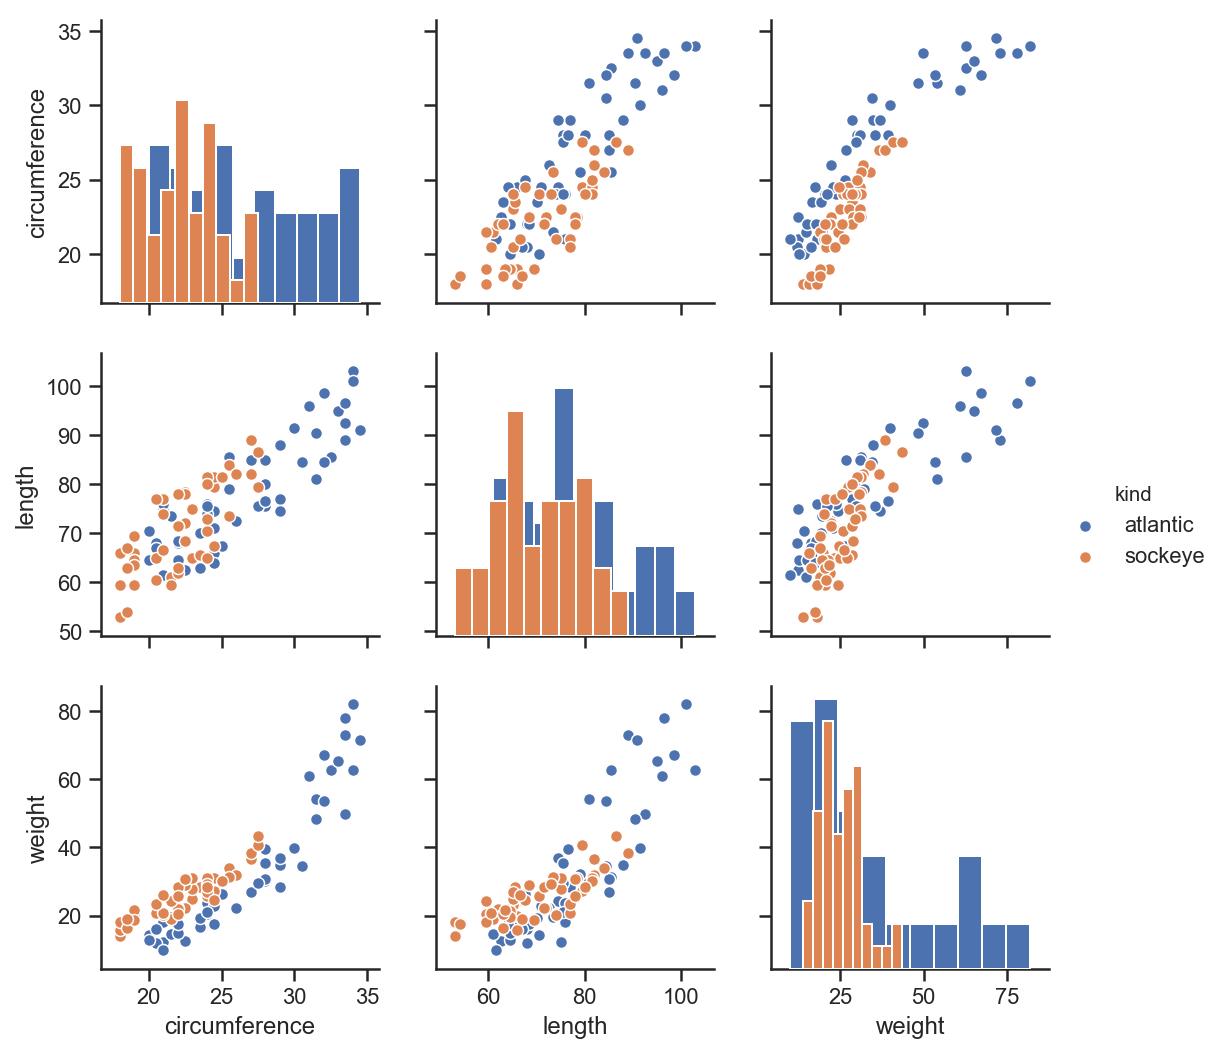

In [210]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(df, hue="kind", diag_kind="hist");

Before we show how to use a regression method, we have to convert the `kind` column to numerical values (`sklearn.preprocessing.LabelEncoder` was mentioned in chapter 6.) first:

In [211]:
from sklearn.preprocessing import LabelEncoder

df.iloc[:, 2] = LabelEncoder().fit_transform(df.iloc[:, 2]) * 1

Now we prepare the data for training and testing:

In [212]:
from sklearn.model_selection import train_test_split

features = df.iloc[:, :-1]
values = df.iloc[:, -1]

(features_train, features_test, 
 values_train, 
 values_test) = train_test_split(features, values, random_state=42)

Without further explanation we pick a regression algorithm, more about regrssion algorithms will be discussed later:

In [213]:
from sklearn.kernel_ridge import KernelRidge
kr = KernelRidge(alpha=.1, kernel="rbf", gamma=.1)

Regression methods in `scikit-learn` also have `fit` and `predict` methods:

In [214]:
kr.fit(features_train, values_train)
predicted = kr.predict(features_test)

Let us plot how good given and predicted values match on the training data set (sic !).

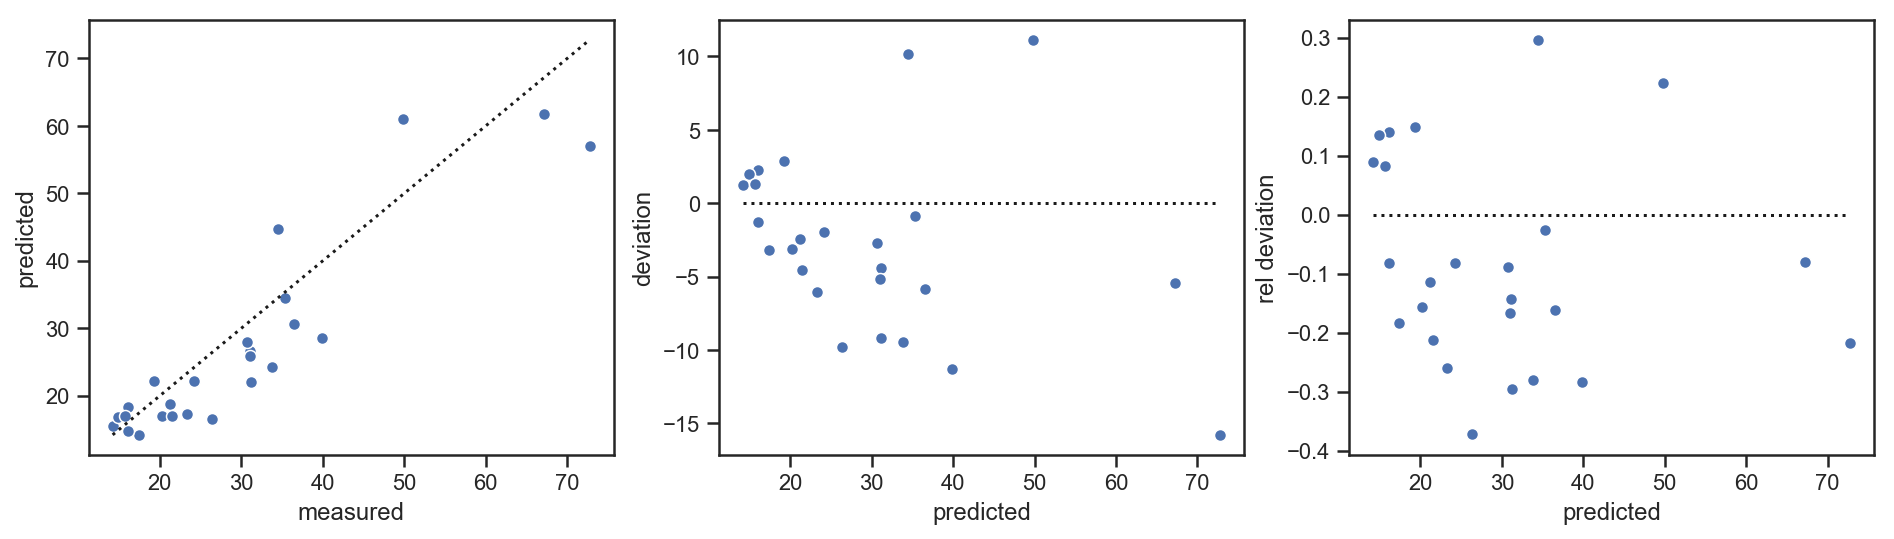

In [219]:
def plot_fit_quality(values_test, predicted):

    mi, ma = min(values_test), max(values_test)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)

    sns.scatterplot(values_test, predicted) 

    plt.plot([mi, ma], [mi, ma], "k:")
    plt.xlabel("measured")
    plt.ylabel("predicted");

    plt.subplot(1, 3, 2)

    sns.scatterplot(values_test, predicted - values_test) 
    plt.plot([mi, ma], [0, 0], "k:")
    plt.xlabel("predicted")
    plt.ylabel("deviation");
    
    plt.subplot(1, 3, 3)

    sns.scatterplot(values_test, (predicted - values_test) / values_test) 
    plt.plot([mi, ma], [0, 0], "k:")
    plt.xlabel("predicted")
    plt.ylabel("rel deviation");
    
    
plot_fit_quality(values_test, predicted)

For assessing the quality of the predictions of a regression method, we can use multiple methods which we will discuss later in this script.

For our current example we compute the average absolute difference between given values $y_i$ and predicted values  $\hat{y}_i$. Thus

$$
\frac{1}{n} \left(|y_1 - \hat{y}_1| + |y_2 - \hat{y}_2| + ... + |y_n - \hat{y}_n| \right)
$$

This is called **mean absolute error**.

mean absolute error: 5.35144698789554


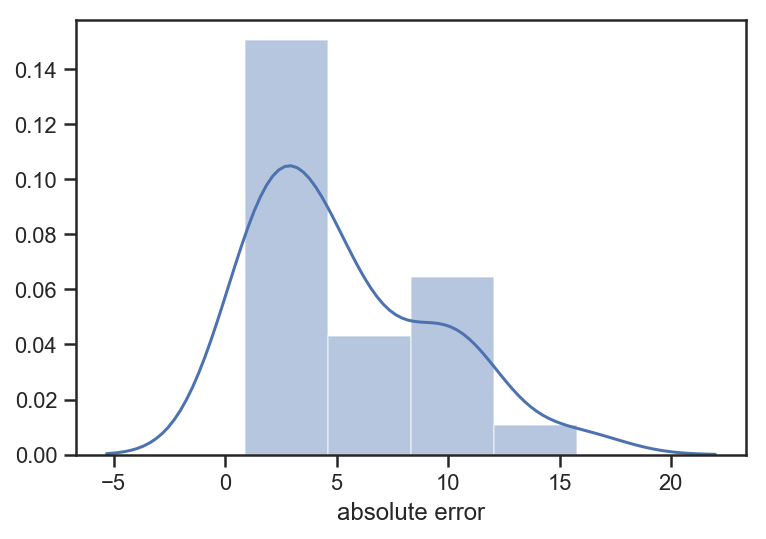

In [220]:
import numpy as np

# mean abso.ute error

abs_error = np.abs(predicted - values_test) 
mean_abs_error = np.mean(abs_error)

print("mean absolute error:", mean_abs_error)

sns.distplot(abs_error)
plt.xlabel("absolute error");

## Metrics / error measures

When we used classification metrics (like accuracy, precision, recall, F1) high values indicated good classification performance. 

Most regression metrics turn this upside down. E.g. smaller values indicate a better regression model.

The hyperparameter optimization functions from `scikit-learn` select configurations which yield a large score. To make regression functions work in this framework, we have to flip the sign of the error value to achieva a usable score.

E.g.

- an average absolute error of 0.1 is scored as -0.1
- an average absolute error of 0.2 is scored as -0.2

In this situation the first case would be prefered: higher score indicates lower error.
   

`scikit-learn` offers the following metrics for measuring regression quality:

### 1. Mean absolute error

This is the metric we used before. Formula is

$$
\frac{1}{n} \left(|y_1 - \hat{y}_1| + |y_2 - \hat{y}_2| + ... + |y_n - \hat{y}_n| \right)
$$

The name of the corresponding score in `scikit-learn` is `neg_mean_absolute_error`.


### 2. Mean squared error

Here we replace the absolute difference by its squared value.

$$
\frac{1}{n} \left((y_1 - \hat{y}_1)^2 + (y_2 - \hat{y}_2)^2 + ... + (y_n - \hat{y}_n)^2 \right)
$$

This measure is more sensitive to outliers: A few larger differences contribute more significantly to a larger mean squared error. The name of the corresponding score in `scikit-learn` is `neg_mean_squared_error`.


### 3. Median absolute error

Here we replace mean calculation by median:

$$
median\left(|y_1 - \hat{y}_1|, |y_2 - \hat{y}_2|, ..., |y_n - \hat{y}_n| \right)
$$

This measure is less sensitive to outliers than the metrics we discussed before: A few larger differences will not contribute significantly to a larger error value. The name of the corresponding score in `scikit-learn` is `neg_median_absolute_error`.

### 4. Mean squared log error

The formula for this metric can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error). 

This metric is recommended when your target values are distributed over a huge range of values, like popoluation numbers. 
The previous error metrics would put a larger weight on large target values. One could consider relative deviations to compensate such effects but relative deviations come with other problems like division by zero.


The name is `neg_mean_squared_log_error`


### 5. Explained variance and $r^2$-score

Two other scores to mention are *explained variance* and $r^2$-score. For both larger values indicate better regression results.

The formula for [r2 can be found here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score), the score takes values in the range $0 .. 1$. The name within `scikit-learn` is `r2`.

The formula for [explained variance](https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score), the score takes values up to $1$. The name within `scikit-learn` is `explained_variance`.


## Some algorithms from sklearn

- `sklearn.linear_model.LinearRegression` is a linear regression method, which only works well for target values which can be described as a linear combination of feature values.


- `sklearn.kernel_ridge.KernelRidge` is [documented here](https://scikit-learn.org/stable/modules/kernel_ridge.html#kernel-ridge). It combines the kernel trick from SVMs with classical least squares regression.


- `sklearn.svm.SVR` is an extension of support vector classification concept to regression, [you find examples here](https://scikit-learn.org/stable/modules/svm.html#svm-regression)


- `sklearn.neighbors.KNeighborsRegressor` extends the idea of nearest neighbour classification to regression: Search for similar data points in the learning data set and compute the predicted value from the values from the neighbourhood, e.g. by averaging or by linear interpolation. [Documentation is available here](https://scikit-learn.org/stable/modules/neighbors.html#regression)


- `sklearn.tree.DecisionTreeRegressor` expands the concept of decision trees to regression [is documented here](https://scikit-learn.org/stable/modules/tree.html#regression).




## A full pipeline

Let us now try to find a good regressor using `scikit-learn`s hyper-parameter tuning:

cross val score: -5.097975303249359


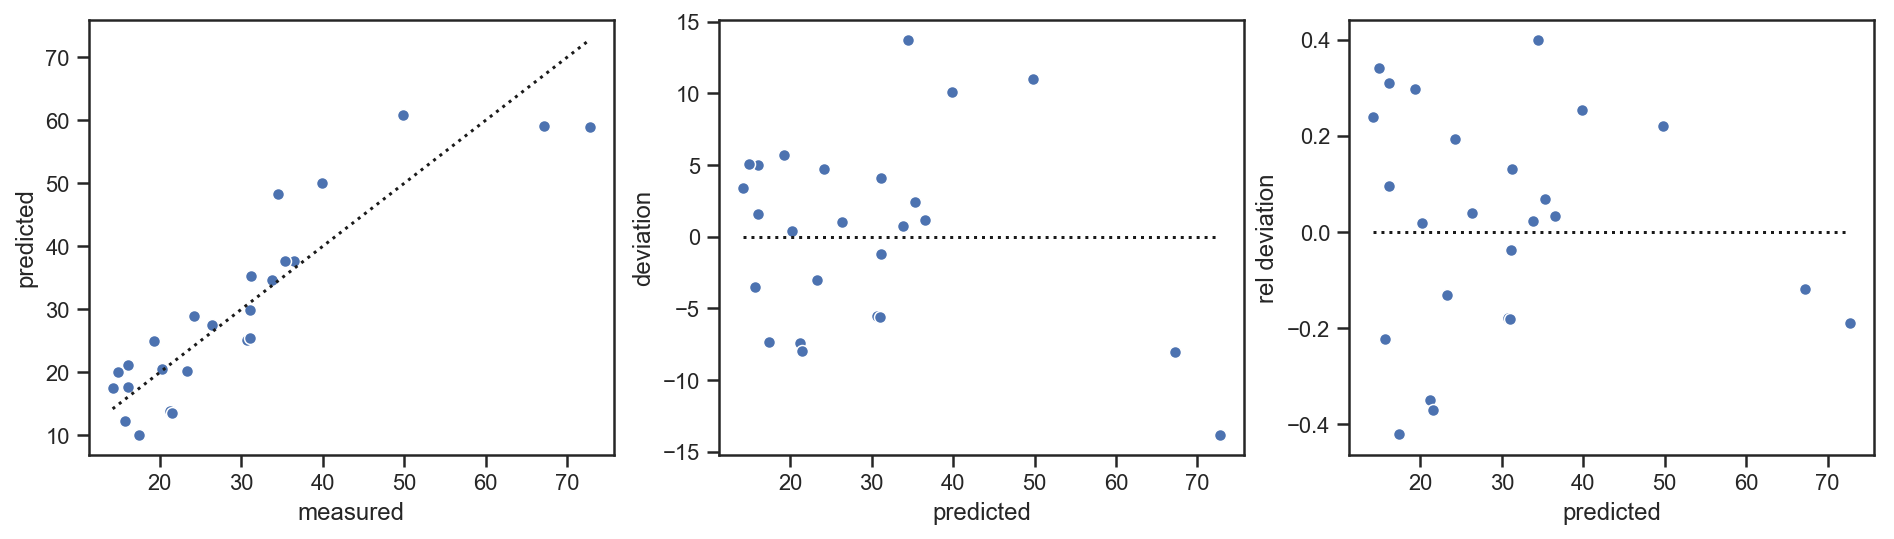

In [221]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA


def eval_regression(p):
    score = cross_val_score(p, features, values, scoring="neg_median_absolute_error", cv=5).mean()
    print("cross val score:", score)
  
    predicted = p.fit(features_train, values_train).predict(features_test)
    plot_fit_quality(values_test, predicted)

    
p = make_pipeline(PolynomialFeatures(2), PCA(2), LinearRegression())
eval_regression(p)

In [222]:
p = make_pipeline(PolynomialFeatures(), PCA(), LinearRegression())

param_grid = {'polynomialfeatures__degree': range(3, 6),
              'pca__n_components': range(3, 13),
             }

In [223]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(p, param_grid, scoring="neg_median_absolute_error", cv=5, n_jobs=4)

search.fit(features, values)

print("Best parameter (CV median absolute error=%0.3f):" % -search.best_score_)
print()
print(search.best_params_)

Best parameter (CV median absolute error=2.246):

{'pca__n_components': 9, 'polynomialfeatures__degree': 3}


cross val score: -2.44524707306135


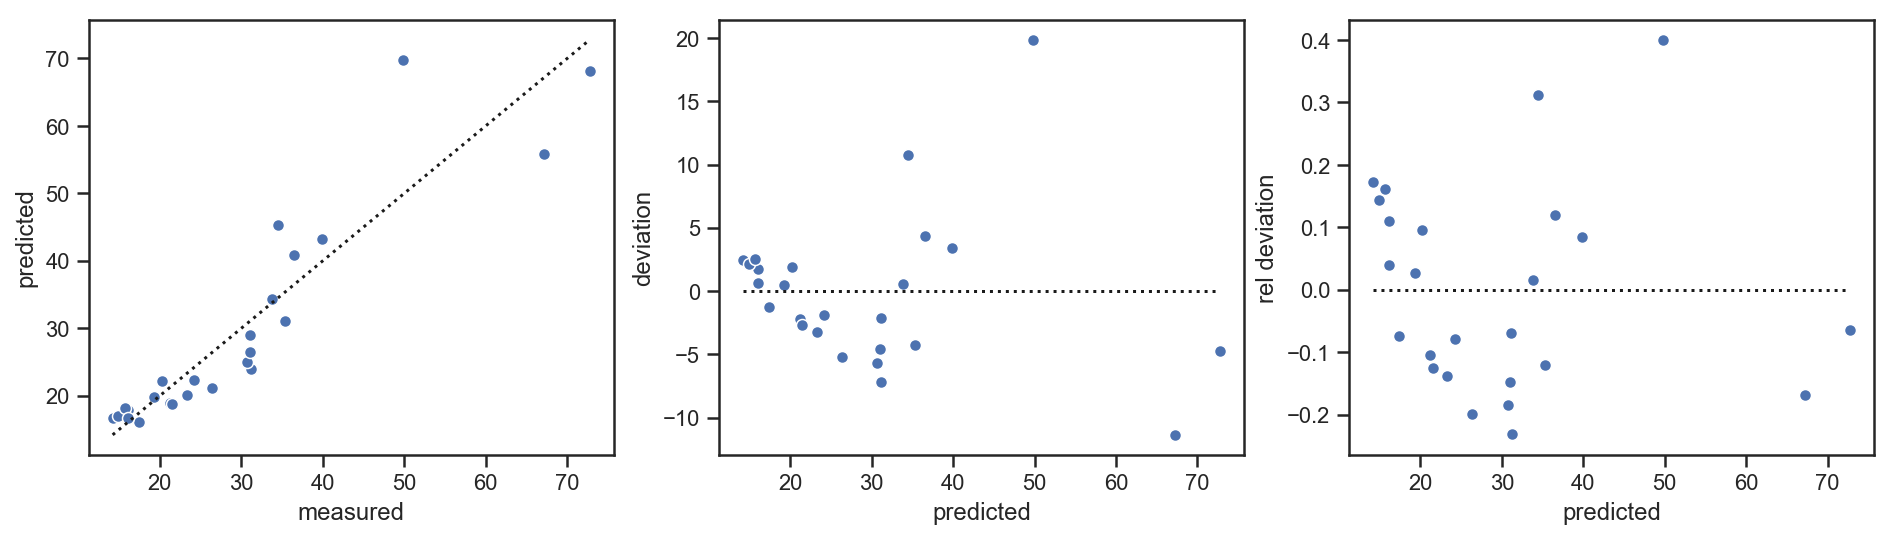

In [224]:
eval_regression(search)

# Exercise section

Play with the examples above and try different algorithms, metrics and pipelines.


## Optional exercise

Split the dataset into one with `kind="sockeye"` and one with `kind="atlantic"` and build individual regression models for both. How does this approach compare to the results we got before ?